In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import keras.backend as K
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
#from sklearn.svm import OneClassSVM
import joblib
from joblib import dump, load
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import MeanSquaredError
from keras.regularizers import l2, l1
from keras.models import model_from_json

In [2]:
json_file = open('rbm_u_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
rbm_model_u = model_from_json(loaded_model_json)
rbm_model_u.load_weights("rbm_u_1.h5")

json_file = open('lstm_u_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
autoencoder_u = model_from_json(loaded_model_json)
autoencoder_u.load_weights("lstm_u_1.h5")
model_if_u = load('if_u_1.joblib')

In [3]:
json_file = open('rbm_n_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
rbm_model_n = model_from_json(loaded_model_json)
rbm_model_n.load_weights("rbm_n_1.h5")

json_file = open('lstm_n_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
autoencoder_n = model_from_json(loaded_model_json)
autoencoder_n.load_weights("lstm_n_1.h5")
model_if_n = load('if_n_1.joblib')

In [63]:
filePath = "C:/Users/raul.blanco/Documents/4 - Personales/UBA/Repositorios/IA/Trabajo-Final/test_data_u.csv"
test_data_u = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=",")
filePath = "C:/Users/raul.blanco/Documents/4 - Personales/UBA/Repositorios/IA/Trabajo-Final/y_test_u.csv"
y_test_u = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=",")

In [64]:
feature = 'bt'
anomaly_percentage_test = 0.01
sample_indices_test = test_data_u.sample(frac=anomaly_percentage_test, random_state=42).index
num_anomalies_test = int(len(test_data_u) * anomaly_percentage_test)+1
test_data_u.loc[sample_indices_test, feature] = np.random.normal(loc=40, scale=1.5, size=len(sample_indices_test))
#test_data.loc[sample_indices_test, feature] = np.random.uniform(low=0, high=100, size=len(sample_indices_test))

In [65]:
y_test_u = y_test_u.drop(['Unnamed: 0'], axis=1)
test_timedelta_u = test_data_u[['timedelta']]
test_timedelta_u = test_data_u.drop(['timedelta.1'], axis=1)
test_data_u = test_data_u.drop(['timedelta.1', 'timedelta', 'Unnamed: 0'], axis=1)

In [67]:
scaler = StandardScaler()
X_test_scaled_u = scaler.fit_transform(test_data_u)
componentes = 9
pca = PCA(n_components = componentes)
#X_test_pca_u = pca.fit_transform(test_data_u)
X_test_pca_u = pca.fit_transform(X_test_scaled_u)
data_test_X_u = X_test_pca_u

In [68]:
X_test_pred_RBM_u = rbm_model_u.predict(data_test_X_u)
#X_test_3d_u = X_test_pca_u.reshape(X_test_pca_u.shape[0], 1, X_test_pca_u.shape[1])
#X_test_pred_LSTM_u = autoencoder_u.predict(X_test_3d_u)
#X_test_pred_if_u = model_if_u.predict(data_test_X_u)

47320/47320 [==============================] - 30s 629us/step


In [24]:
#X_test_pred_if_u = np.where(X_test_pred_if_u == 1, 0, np.where(X_test_pred_if_u == -1, 1, X_test_pred_if_u))

In [69]:
X_test_pred_RBM_n = rbm_model_n.predict(data_test_X_u)

47320/47320 [==============================] - 42s 890us/step


Threshold_u =  3.5
Threshold_n =  3.5


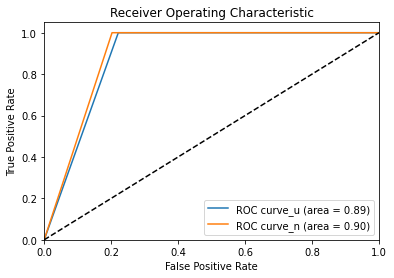

AUC_u: 0.8893354235111652
AUC_n: 0.8986971966045728
Threshold =  3.5


In [71]:
threshold_u = float(input("Ingrese el Threshold a utilizar (uniform): "))
print("Threshold_u = ", threshold_u)
y_test_pred_u = np.where(np.linalg.norm(data_test_X_u - X_test_pred_RBM_u, axis=1) > threshold_u, 1, 0)
fpr_u, tpr_u, thresholds = roc_curve(y_test_u, y_test_pred_u)
roc_auc_u = auc(fpr_u, tpr_u)

threshold_n = float(input("Ingrese el Threshold a utilizar (normal): "))
print("Threshold_n = ", threshold_n)
y_test_pred_n = np.where(np.linalg.norm(data_test_X_u - X_test_pred_RBM_n, axis=1) > threshold_n, 1, 0)
fpr_n, tpr_n, thresholds = roc_curve(y_test_u, y_test_pred_n)
roc_auc_n = auc(fpr_n, tpr_n)

plt.figure()
plt.plot(fpr_u, tpr_u, label='ROC curve_u (area = %0.2f)' % roc_auc_u)
plt.plot(fpr_n, tpr_n, label='ROC curve_n (area = %0.2f)' % roc_auc_n)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print('AUC_u:', roc_auc_u)
print('AUC_n:', roc_auc_n)
print("Threshold = ", threshold_n)

In [47]:
# Suponiendo que data_test_X_u es tu ndarray
count_zeros = np.count_nonzero(y_test_pred_n == 0)
count_ones = np.count_nonzero(y_test_pred_n == 1)

print(f"Número de registros con valor 0: {count_zeros}")
print(f"Número de registros con valor 1: {count_ones}")

Número de registros con valor 0: 1178830
Número de registros con valor 1: 335387


In [56]:
# Suponiendo que data_test_X_u es tu ndarray
count_zeros = np.count_nonzero(y_test_u == 0)
count_ones = np.count_nonzero(y_test_u == 1)

print(f"Número de registros con valor 0: {count_zeros}")
print(f"Número de registros con valor 1: {count_ones}")

Número de registros con valor 0: 1499075
Número de registros con valor 1: 15142
